# Continual Learning
이번 시간에는 Continual Learning에 대해 실습하는 시간을 가져봅니다.
이번 실습을 통해 Continual Learning을 코드로 구현하고
Continual Learning의 문제점 중 하나인 **Catastrophic forgetting**을 확인합니다.
또한 Continual Learning에서 유명한 방법중 하나인 **GDumb**을 구현해보고 보다 개선된 결과를 확인합니다.

In [1]:
# Import Library
import torch
import torch.nn as nn
from torch import Tensor

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST

import numpy as np

import copy
import random
from tqdm import tqdm
from PIL import Image
from matplotlib import pyplot as plt
from typing import Callable, List, Optional, Tuple, Any

## Section 1: Implementing ContinualDataset
Continual Learning을 위한 Dataset을 구현합니다.

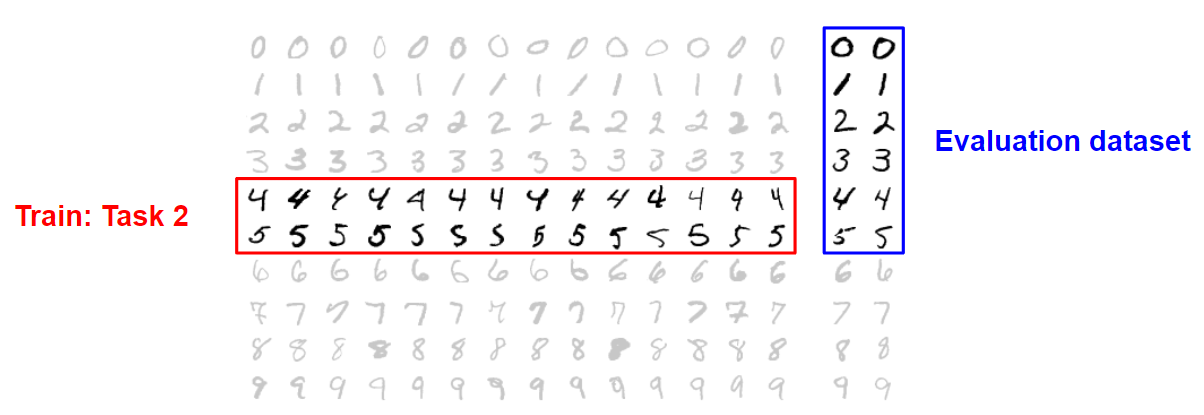

ContinualDataset은 기존의 dataset(MNIST)을 여러개의 task단위로 쪼개어 Continual Learning setting에 맞게 변경해주는 역할을 합니다. ContinualDataset은 다음의 함수들로 이루어져 있습니다.
* change_task: dataset의 task를 변경합니다.
* get_sample_list: task에 포함된 data sample들의 index list를 불러옵니다.
* split_dataset: dataset을 여러개의 task로 분할합니다. (구현)

In [2]:
class ContinualDataset(Dataset):
    def __init__(
            self,
            root: str,
            train: bool,
            transform: Optional[Callable],
            num_tasks: int,
    ) -> None:
        """
        Continual Dataset은 기존의 dataset(MNIST)을 여러개의 task로 쪼개어 Continual Learning에 맞게 변경해주는 역할을 합니다.
        :param root: (str) MNIST dataset이 설치될 디렉토리입니다.
        :param train: (bool) 데이터셋이 학습 데이터셋인지, 평가 데이터셋인지를 나타내는 bool형 데이터 입니다. True 이면 학습데이터입니다.
        :param transform: (Optional[Callable]) Data augmentation을 위한 transform 함수입니다.
        :param num_tasks: (int) 총 task 개수입니다.
        """
        # 기존 dataset(MNIST)로 부터 image와 label을 가져옵니다.
        dataset = MNIST(root=root, train=train, download=True)
        self.images = dataset.data
        self.labels = dataset.targets.tolist()
        self.num_classes = len(dataset.classes)

        # 이후에 사용하기 위해 parameter로 받은 num_tasks와 transform을 저장합니다.
        self.num_tasks = num_tasks
        self.transform = transform

        # 기존 dataset(MNIST)를 num_tasks개의 task로 분리합니다.
        self.data_index_list_per_task = self.split_dataset(train=train)
        self.current_task = 0

    def change_task(
            self,
            task_number: int,
    ) -> None:
        """
        dataset의 task를 변경합니다.
        :param task_number: (int) 변경할 task 번호입니다.
        """
        self.current_task = task_number

    def get_data_index_list(
            self,
            task_number: Optional[int] = None,
    ) -> List[int]:
        """
        task에 포함된 data sample들의 index list를 불러옵니다.
        :param task_number: (int) 가져올 task의 번호입니다.
        :return: (List[int]) task에 포함된 data의 index list 입니다.
        """
        if task_number is None:
            return copy.deepcopy(self.data_index_list_per_task[self.current_task])
        return copy.deepcopy(self.data_index_list_per_task[task_number])

    def split_dataset(
            self,
            train: bool,
    ) -> List[List[int]]:
        """
        dataset을 여러개의 task로 분할합니다.
        구현의 편의를 위해 다음을 보장합니다.
        1. class 수는 task 수의 배수임을 보장합니다. (num_class % num_task = 0)
        2. 각 task에 포함된 class는 항상 오름차순으로 배정됩니다.
        :param train: (bool) 데이터셋이 학습 데이터셋인지, 평가 데이터셋인지를 나타내는 bool형 데이터 입니다. True 이면 학습데이터입니다.
        :return: (List[List[int]]) 각 task에 포함된 data의 index list 입니다.
        """

        ########################
        ## Need to Implement! ##
        ########################
        # class가 어떤 task에 포함되는지를 mapping해주는 class_to_task를 만듭니다.
        #  -> "self.num_classes", "self.num_tasks" 사용할 것
        #  -> e.g., if self.num_classes == 6 and self.num_tasks == 2, then
        #           class_to_task == [[0, 1, 2], [3, 4, 5]]
        class_to_task = []
        num_class_per_task = self.num_classes // self.num_tasks
        for task_number in range(self.num_tasks):
          class_to_task.append([])
          for i in range(num_class_per_task):
            class_to_task[-1].append(num_class_per_task * task_number + i)

        ########################

        data_index_list_per_task = [[] for _ in range(self.num_tasks)]
        for data_index, label in enumerate(self.labels):
            ########################
            ## Need to Implement! ##
            ########################
            # 전체 data를 확인하면서 data를 여러개의 task로 분리합니다 (task_number 구현).
            #  -> "task_number = None"에 알맞는 값 넣기
            #  -> "class_to_task", "label" 사용할 것
            task_number = None
            for task_id, task_indices in enumerate(class_to_task):
              if label in task_indices:
                task_number = task_id
            ########################
            data_index_list_per_task[task_number].append(data_index)

        # 만약 testset이라면 이전 task의 data도 전부 포함 시킵니다.
        if not train:
            for task_number in range(1, self.num_tasks):
                data_index_list_per_task[task_number] += data_index_list_per_task[task_number - 1]

        return data_index_list_per_task

    def __len__(self):
        """
        dataset의 길이를 반환합니다.
        :return: (int) dataset의 길이입니다.
        """
        return len(self.data_index_list_per_task[self.current_task])

    def __getitem__(
            self,
            index: int,
    ) -> Tuple[Any, Any]:
        """
        index에 해당하는 data를 가져옵니다.
        :param index: (int) 가져올 data의 index입니다.
        :return: (Tuple[Any, Any]) (image, label)을 갖고 있는 Tuple입니다.
        """
        data_index = self.data_index_list_per_task[self.current_task][index]
        image, label = self.images[data_index], self.labels[data_index]

        image = Image.fromarray(image.numpy(), mode='L')

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [3]:
# Test Code
train_dataset = ContinualDataset(root='./dataset', train=True, transform=None, num_tasks=5)
test_dataset = ContinualDataset(root='./dataset', train=False, transform=None, num_tasks=5)
train_data_size = [12665, 12089, 11263, 12183, 11800]
test_data_size = [2115, 4157, 6031, 8017, 10000]
for task_number in range(5):
    train_dataset.change_task(task_number=task_number)
    assert len(train_dataset) == train_data_size[task_number]
    for data_index in range(len(train_dataset)):
        image, label = train_dataset[data_index]
        assert label in [2 * task_number, 2 * task_number + 1]

    test_dataset.change_task(task_number=task_number)
    assert len(test_dataset) == test_data_size[task_number]
    for data_index in range(len(test_dataset)):
        image, label = train_dataset[data_index]
        assert label < (task_number + 1) * 2
print("Test Complete!")

100%|██████████| 9912422/9912422 [00:00<00:00, 340555620.36it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 90265047.56it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 238948671.41it/s]


Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5557330.45it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



Test Complete!


## Section 2: Implementing MLP Model
Dataset을 학습할 총 3개의 fully connected layer로 이루어진 간단한 model을 구현합니다.

In [4]:
class FCBlock(nn.Module):
    def __init__(
            self,
            in_features: int,
            out_features: int,
            bias: bool = False,
    ) -> None:
        """
        Linear, BatchNorm, ReLU로 이루어진 FCBlock을 생성합니다.
        :param in_features: (int) Linear layer의 input feature size입니다.
        :param out_features: (int) Linear layer의 output feature size와 BatchNorm1d의 num_feature size입니다.
        :param bias: (bool) Linear layer에서 bias를 사용할지를 나타내는 bool형 데이터 입니다. True이면 bias를 사용합니다.
        """
        super(FCBlock, self).__init__()
        layer = [
            nn.Linear(in_features=in_features,
                      out_features=out_features,
                      bias=bias),
            nn.BatchNorm1d(num_features=out_features),
            nn.ReLU(inplace=True),
        ]
        self.block = nn.Sequential(*layer)

    def forward(
            self,
            x: Tensor
    ) -> Tensor:
        return self.block(x)


class MLP(nn.Module):
    def __init__(
            self,
            hidden_features: int,
            num_classes: int = 10,
    ) -> None:
        """
        총 3개의 FCLayer로 이루어져 있는 간단한 모델입니다.
        :param hidden_features: (int) 중간 hidden feature의 size입니다.
        :param num_classes: (int) classfy를 할 class 개수 입니다. 마지막 layer의 output size로 사용됩니다.
        """
        super(MLP, self).__init__()
        self.layer1 = FCBlock(in_features=28 * 28, out_features=hidden_features, bias=True)
        self.layer2 = FCBlock(in_features=hidden_features, out_features=hidden_features, bias=True)
        self.fc = nn.Linear(in_features=hidden_features, out_features=num_classes, bias=True)

    def forward(
            self,
            x: Tensor
    ) -> Tensor:
        out = x.view(x.size(0), -1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.fc(out)

        return out


def mlp400(num_classes=10):
    return MLP(hidden_features=400, num_classes=num_classes)

## Section 3: Implementing Continual Learning Base Method
Continual Learning 학습 방법을 구현합니다.
BaseMethod는 다음과 같은 함수들로 이루어져 있습니다.
* train, train_one_epoch, evaluation: model을 학습 및 평가하는 함수입니다.
* cal_metric, cal_nan_avg, cal_accuracy_last, cal_accuracy_avg: model의 성능을 측정하는 함수입니다.
* draw_class_bar_graph, draw_task_graph: 결과를 visualize 해주는 함수입니다.

In [5]:
class BaseMethod:
    def __init__(
            self,
            data_root: str,
            num_tasks: int,
    ) -> None:
        """
        Continual Learning을 하는 가장 기본적인 방법입니다.
        학습 방법은 다음과 같습니다.
        1. 매 task마다 dataset을 update합니다.
        2. update된 dataset을 사용해서 model을 학습합니다.
        :param data_root: (str) dataset이 설치될 디렉토리입니다.
        :param num_tasks: (int) 총 task 개수입니다.
        """
        self.num_tasks = num_tasks
        self.num_epochs = 5
        # 데이터셋을 준비합니다.
        inp_size = 28
        data_mean, data_std = (0.1307,), (0.3081,)
        self.train_transform = transforms.Compose([
            transforms.Resize((inp_size, inp_size)),
            transforms.RandomCrop(inp_size, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(data_mean, data_std),
        ])
        self.test_transform = transforms.Compose([
            transforms.Resize((inp_size, inp_size)),
            transforms.ToTensor(),
            transforms.Normalize(data_mean, data_std),
        ])

        self.train_dataset = ContinualDataset(root=data_root,
                                              train=True,
                                              transform=self.train_transform,
                                              num_tasks=num_tasks)
        self.test_dataset = ContinualDataset(root=data_root,
                                             train=False,
                                             transform=self.test_transform,
                                             num_tasks=num_tasks)

        # 학습을 위한 모델을 준비합니다.
        self.num_classes = 10
        self.model = mlp400(num_classes=self.num_classes).cuda()
        self.optimizer = torch.optim.SGD(self.model.parameters(),
                                         lr=0.05,
                                         momentum=0.9,
                                         nesterov=True,
                                         weight_decay=1e-4)

        self.criterion = torch.nn.CrossEntropyLoss()

    def train(self):
        task_records = []
        for task_number in range(self.num_tasks):
            # 데이터셋을 해당 task에 맞게 업데이트 합니다.
            self.train_dataset.change_task(task_number=task_number)
            self.test_dataset.change_task(task_number=task_number)

            train_loader = DataLoader(self.train_dataset, shuffle=True, batch_size=64, num_workers=2, drop_last=True)
            test_loader = DataLoader(self.test_dataset, shuffle=False, batch_size=64, num_workers=2)

            # 모델을 학습합니다.
            for epoch in tqdm(range(self.num_epochs)):
                self.train_one_epoch(train_loader)

            # 각 task마다 모델을 평가합니다.
            class_accuracy = self.evaluation(test_loader)
            self.draw_class_bar_graph(class_accuracy)
            print(['%.2lf' % (acc * 100) for acc in class_accuracy], flush=True)
            task_records.append(class_accuracy)

        # 전체 task에 걸쳐서 모델을 평가합니다.
        self.draw_task_graph(task_records)
        self.cal_metric(task_records)

    def train_one_epoch(self, train_loader):
        self.model.train()
        for data in train_loader:
            image, label = data[0].cuda(), data[1].cuda()

            self.optimizer.zero_grad()

            output = self.model(image)
            loss = self.criterion(output, label)
            loss.backward()
            self.optimizer.step()

    @torch.no_grad()
    def evaluation(self, test_loader):
        correct, num_data = torch.zeros([self.num_classes]).cuda(), torch.zeros([self.num_classes]).cuda()
        self.model.eval()
        for data in test_loader:
            image, label = data[0].cuda(), data[1].cuda()

            output = self.model(image)

            pred = torch.topk(output, k=1, dim=1)[1]
            mask = pred[:, 0] == label

            correct.index_add_(0, label[mask], torch.ones_like(label[mask], dtype=torch.float))
            num_data.index_add_(0, label, torch.ones_like(label, dtype=torch.float))

        return correct / num_data

    def cal_metric(self, task_records):
        print("A_last: %.2lf | A_avg: %.2lf" % (
            self.cal_accuracy_last(task_records),
            self.cal_accuracy_avg(task_records),
        ))

    @staticmethod
    def cal_nan_avg(class_accuracy):
        return (torch.nansum(class_accuracy) / (~torch.isnan(class_accuracy)).sum()).item()

    def cal_accuracy_last(self, task_records):
        return self.cal_nan_avg(task_records[-1]) * 100

    def cal_accuracy_avg(self, task_records):
        task_accuracy = []
        for task_number in range(len(task_records)):
            task_accuracy.append(self.cal_nan_avg(task_records[task_number]))
        return torch.mean(torch.tensor(task_accuracy)).item() * 100

    def draw_class_bar_graph(self, class_accuracy):
        x = np.arange(self.num_classes)

        plt.bar(x, np.array(class_accuracy.cpu()))
        plt.xticks(x, x)

        plt.xlabel('Class')
        plt.ylabel('Accuracy')

        plt.show()

    def draw_task_graph(self, task_records):
        task_accuracy = []
        for task_number in range(len(task_records)):
            task_accuracy.append(self.cal_nan_avg(task_records[task_number]))

        plt.plot(np.array(task_accuracy), marker='o')
        plt.xticks(np.arange(self.num_tasks), np.arange(self.num_tasks) + 1)
        plt.yticks(np.arange(0, 1.1, step=0.1))
        plt.xlabel('Task')
        plt.ylabel('Accuracy')

        for i, j in zip(np.arange(self.num_tasks), task_accuracy):
            plt.text(i, j, '%.2lf' % (j * 100))

        plt.show()

## Section 4: Comparison of Joint Training and Continual Learning
Joint Training과 Continual Learning을 비교해 봅니다.

100%|██████████| 5/5 [01:55<00:00, 23.09s/it]


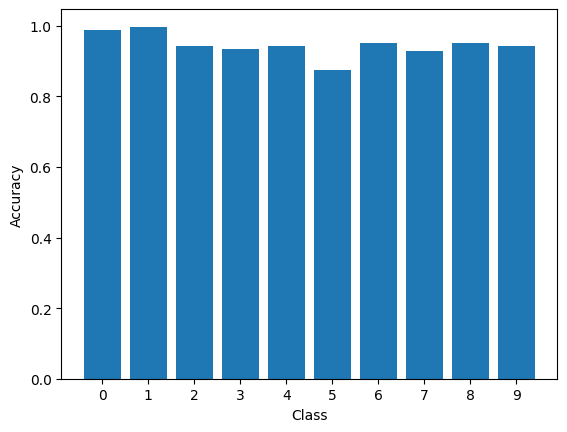

['98.67', '99.74', '94.38', '93.37', '94.20', '87.56', '94.99', '92.80', '95.17', '94.35']


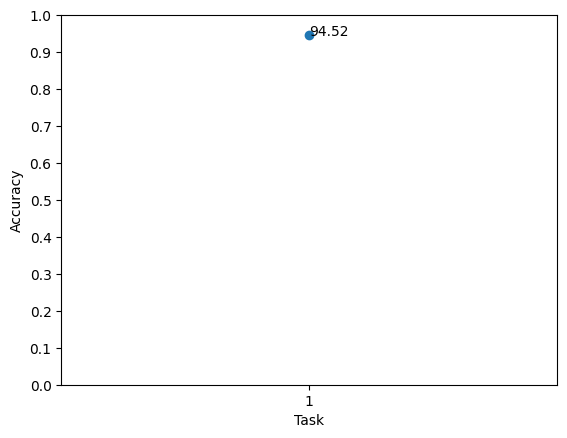

A_last: 94.52 | A_avg: 94.52


In [6]:
# Joint Training
joint_training = BaseMethod(data_root='./dataset', num_tasks=1)
joint_training.train()

전체 task가 5개인 상황에서 continual learning을 진행하여 봅시다.

100%|██████████| 5/5 [00:23<00:00,  4.79s/it]


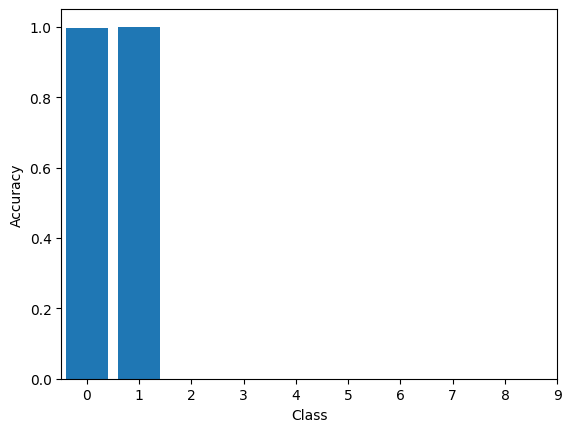

['99.69', '100.00', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']


100%|██████████| 5/5 [00:22<00:00,  4.58s/it]


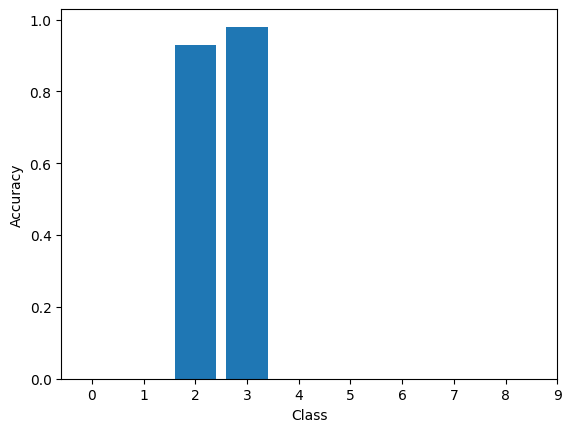

['0.00', '0.00', '93.02', '98.02', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']


100%|██████████| 5/5 [00:21<00:00,  4.37s/it]


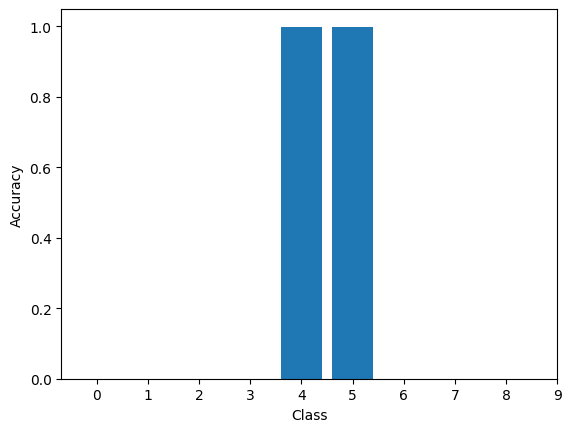

['0.00', '0.00', '0.00', '0.00', '99.90', '99.89', 'nan', 'nan', 'nan', 'nan']


100%|██████████| 5/5 [00:23<00:00,  4.65s/it]


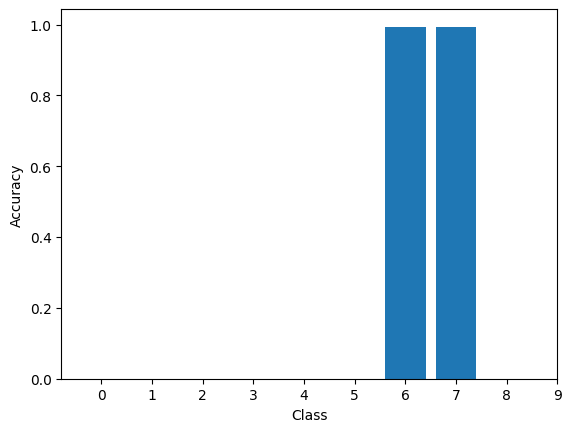

['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '99.27', '99.42', 'nan', 'nan']


100%|██████████| 5/5 [00:22<00:00,  4.53s/it]


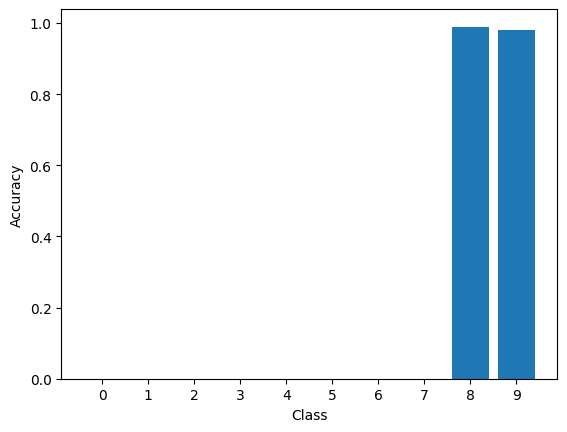

['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '98.97', '98.02']


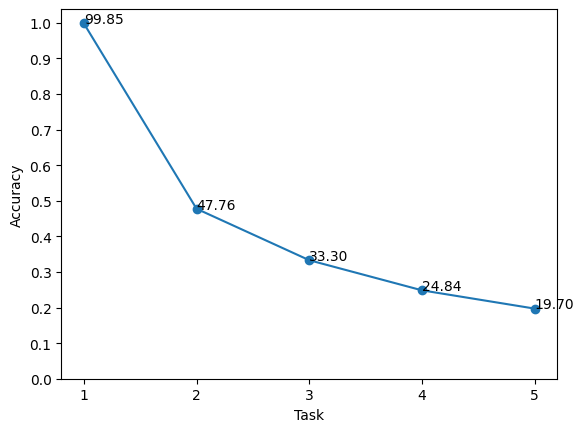

A_last: 19.70 | A_avg: 45.09


In [7]:
# Continual Learning
continual_learning = BaseMethod(data_root='./dataset', num_tasks=5)
continual_learning.train()

그래프를 보면 알수 있듯이, model이 다음 task를 배우면 이전에 배웠던 task들을 잊어버리는 문제가 발생합니다. 이를 **Catastrophic forgetting**이라고 부릅니다.

지금까지 우리는 Continual Learning을 구현하고, Continual Learning이 가지는 문제점 중 하나인 Catastrophic forgetting 문제를 확인했습니다. 다음은 sample-memory base method중 하나인 GDumb 을 구현하고 보다 개선된 결과를 확인해봅니다.

## Section 5: Implementing GDumb - Greedy Sampler

GDumb method의 Greedy Sampler를 구현합니다. Greedy Sampler는 아주 간단한 sample memory method입니다. Greedy Sampler는 매번 새로운 sample을 받을 때 마다, sample memory에 sample을 집어넣습니다. 만약 Greedy Sampler의 sample memory가 제한된 memory size를 초과하면 sample수가 가장 많은 class에서 random하게 하나의 sample을 삭제합니다.

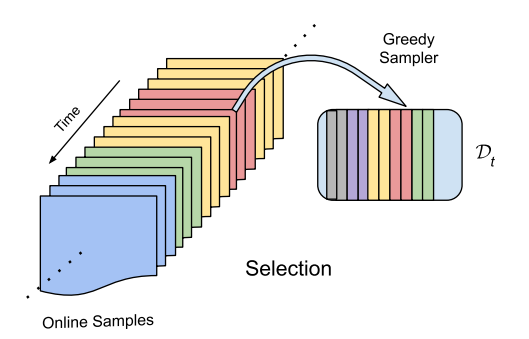

GreedySampler는 다음과 같은 함수들로 이루어져 있습니다.
* update_memory: task에 포함된 data stream을 받아 sample memory를 update합니다.
* greedy_sampling: data sample 하나를 받아서 sample memory를 update합니다.

In [8]:
class GreedySampler(Dataset):
    def __init__(
            self,
            root: str,
            train: bool,
            transform: Optional[Callable],
            memory_size: int,
    ) -> None:
        """
        GDumb의 Greedy Sampler입니다.
        :param root: (str) MNIST dataset이 설치될 디렉토리입니다.
        :param train: (bool) 데이터셋이 학습 데이터셋인지, 평가 데이터셋인지를 나타내는 bool형 데이터 입니다. True 이면 학습데이터입니다.
        :param transform: (Optional[Callable]) Data augmentation을 위한 transform 함수입니다.
        :param memory_size: (int) Sample을 저장할 수 있는 최대 Memory size입니다.
        """
        # 기존 dataset(MNIST)로 부터 image와 label을 가져옵니다.
        dataset = MNIST(root=root, train=train, download=True)
        self.images = dataset.data
        self.labels = dataset.targets.tolist()
        self.num_classes = len(dataset.classes)

        # 이후에 사용하기 위해 parameter로 받은 memory_size와 transform을 저장합니다.
        self.maximum_memory_size = memory_size
        self.transform = transform

        # Sample Memory를 생성합니다.
        self.sample_memory = []
        self.current_memory_size = 0
        self.sample_memory_per_class = [[] for _ in range(self.num_classes)]
        self.current_memory_size_per_class = [0 for _ in range(self.num_classes)]

    def update_memory(
            self,
            new_sample_list: List[int],
    ) -> None:
        """
        새로운 Data Sample List를 받아서 GreedySampler의 sample memory를 update합니다.
        :param new_sample_list: (List[int]) 새롭게 받은 data sample의 index로 이루어진 list입니다.
        """

        for new_sample_index in new_sample_list:
            ########################
            ## Need to Implement! ##
            ########################
            # Each data sample in new task
            #  -> use "self.labels" and "new_sample_idx" to assign the label
            # new_sample_label = None
            new_sample_label = self.labels[new_sample_index]
            ########################
            self.sample_memory_per_class = self.greedy_sampling(new_sample_index=new_sample_index,
                                                                new_sample_label=new_sample_label)

        self.sample_memory = []
        for class_number in range(self.num_classes):
            ########################
            ## Need to Implement! ##
            ########################
            # Update the memory
            #  -> use "self.sample_memory_per_class" and "class_number"
            # sample_memory_per_class = None
            sample_memory_per_class = self.sample_memory_per_class[class_number]
            ########################
            self.sample_memory.extend(sample_memory_per_class)

        assert len(self.sample_memory) <= self.maximum_memory_size

    def greedy_sampling(
            self,
            new_sample_index: int,
            new_sample_label: int,
    ) -> List[List[int]]:
        """
        새로운 Data Sample을 하나 받아서 GreedySampler의 sample memory를 update합니다.
        greedy_sampling을 다음과 같은 과정을 거칩니다.
        1. 새롭게 받은 sample을 memory에 집어넣습니다.
        2. 만약 Greedy Sampler의 memory size가 수용할 수 있는 maximum memory size를 초과하였을 경우,
           sample수가 가장 많은 class에서 random하게 하나의 sample을 삭제합니다.
        :param new_sample_index: (int) 새롭게 받은 sample의 index 입니다.
        :param new_sample_label: (int) 새롭게 받은 sample의 label 입니다.
        :return: (List[List[int]]) 각 class별로 나뉘어져 있는 sample memory입니다.
        """

        ########################
        ## Need to Implement! ##
        ########################
        # 1. 새롭게 받은 sample(new_sample_index)을 sample label(new_sample_label)에 맞는 memory(self.sample_memory_per_class)에 집어넣습니다.
        # 2. 현재 memory 사이즈(self.current_memory_size)와 해당 클래스(new_sample_label)에 대한 memory 사이즈(self.current_memory_size_per_class)를 1씩 증가합니다.
        self.sample_memory_per_class[new_sample_label].append(new_sample_index)
        self.current_memory_size += 1
        self.current_memory_size_per_class[new_sample_label] += 1

        ########################

        # 만약 Greedy Sampler의 memory size가 수용할 수 있는 maximum memory size를 초과하는 경우
        if self.current_memory_size > self.maximum_memory_size:
            ########################
            ## Need to Implement! ##
            ########################
            # memory(self.current_memory_size_per_class)에서 sample수가 가장 많은 class를 찾습니다.
            # class_to_delete = None
            class_to_delete = self.current_memory_size_per_class.index(max(self.current_memory_size_per_class))
            ########################

            ########################
            ## Need to Implement! ##
            ########################
            # 해당 class(class_to_delete)를 저장한 memory(self.sample_memory_per_class)에서 random하게 하나의 sample을 선택합니다.
            # index_to_delete = None
            index_to_delete = random.choice(self.sample_memory_per_class[class_to_delete])
            ########################

            # 해당 sample을 삭제합니다.
            self.sample_memory_per_class[class_to_delete].remove(index_to_delete)

            ########################
            ## Need to Implement! ##
            ########################
            # 현재 memory 사이즈(self.current_memory_size)와 해당 클래스(class_to_delete)에 대한 memory 사이즈(self.current_memory_size_per_class)를 1씩 감소합니다.
            self.current_memory_size -= 1
            self.current_memory_size_per_class[class_to_delete] -= 1

            ########################

        return self.sample_memory_per_class

    def __len__(self):
        return len(self.sample_memory)

    def __getitem__(self, index):
        data_index = self.sample_memory[index]
        image, label = self.images[data_index], self.labels[data_index]

        image = Image.fromarray(image.numpy(), mode='L')

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [9]:
# Test Code
train_dataset = ContinualDataset(root='./dataset', train=True, transform=None, num_tasks=5)
greedy_sampler = GreedySampler(root='./dataset', train=True, transform=None, memory_size=500)

check_data = [
    [250, 250, 0, 0, 0, 0, 0, 0, 0, 0],
    [125, 125, 125, 125, 0, 0, 0, 0, 0, 0],
    [83, 83, 83, 83, 84, 84, 0, 0, 0, 0],
    [62, 62, 62, 62, 63, 63, 63, 63, 0, 0],
    [50, 50, 50, 50, 50, 50, 50, 50, 50, 50],
]

for task_number in range(5):
    greedy_sampler.update_memory(train_dataset.get_data_index_list(task_number=task_number))
    for class_number in range(10):
        assert len(greedy_sampler.sample_memory_per_class[class_number]) == check_data[task_number][class_number]

print("Test Complete!")

Test Complete!


## Section 6: Implementing GDumb - Dumb Learner

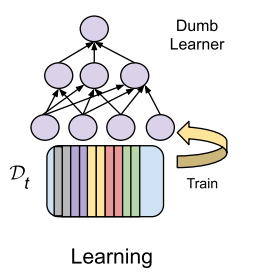

GDumb method의 Dumb Learner를 구현합니다. Dumb Learner는 매 task마다 Greedy Sampler가 저장한 sample memory만을 이용해서 from the scratch로 model을 학습합니다.

In [10]:
class GDumbMethod(BaseMethod):
    def __init__(
            self,
            data_root: str,
            num_tasks: int,
            memory_size: int,
    ) -> None:
        """
        Continual Learning에서 GDumb의 학습방법 (Dumb Learner) 입니다.
        Dumb Learner는 다음과 같은 과정을 거칩니다.
        1. 매 task마다 Greedy Sampler를 update합니다.
        2. 매 task마다 새로운 model을 생성합니다.
        3. 생성된 model을 Greedy Sampler가 저장한 sample memory만을 이용해서 학습합니다.
        :param data_root: (str) dataset이 설치될 디렉토리입니다.
        :param num_tasks: (int) 총 task 개수입니다.
        :param memory_size: (int) Greedy Sampler가 사용할 최대 Memory size입니다.
        """
        super(GDumbMethod, self).__init__(data_root, num_tasks)
        # Greedy Sampler를 생성합니다.
        self.greedy_sampler = GreedySampler(root=data_root,
                                            train=True,
                                            transform=self.train_transform,
                                            memory_size=memory_size)
        # Sample Memory는 기존 dataset에 비해 매우 적은 sample을 들고 있기 때문에, 학습 epoch수를 충분히 늘립니다.
        self.num_epochs = 20

    def train(self):
        task_records = []
        for task_number in range(self.num_tasks):
            # 데이터셋을 해당 task에 맞게 업데이트 합니다.
            self.greedy_sampler.update_memory(self.train_dataset.get_data_index_list(task_number))
            self.test_dataset.change_task(task_number)

            train_loader = DataLoader(self.greedy_sampler, shuffle=True, batch_size=64, num_workers=2, drop_last=True)
            test_loader = DataLoader(self.test_dataset, shuffle=False, batch_size=64, num_workers=2)

            # 모델을 새롭게 가져옵니다.
            self.model, self.optimizer = self.get_new_model()

            # 모델을 학습합니다.
            for epoch in tqdm(range(self.num_epochs)):
                self.train_one_epoch(train_loader)

            # 각 task마다 모델을 평가합니다.
            class_accuracy = self.evaluation(test_loader)
            self.draw_class_bar_graph(class_accuracy)
            print(['%.2lf' % (acc * 100) for acc in class_accuracy], flush=True)
            task_records.append(class_accuracy)

        # 전체 task에 걸쳐서 모델을 평가합니다.
        self.cal_metric(task_records)
        self.draw_task_graph(task_records)

    def get_new_model(self):
        model = mlp400(num_classes=self.num_classes).cuda()
        optimizer = torch.optim.SGD(model.parameters(),
                                    lr=0.05,
                                    momentum=0.9,
                                    nesterov=True,
                                    weight_decay=1e-4)

        return model, optimizer

## Section 7: Train GDumb
구현한 GDumb 방법으로 모델을 학습을 해봅니다.

100%|██████████| 20/20 [00:04<00:00,  4.06it/s]


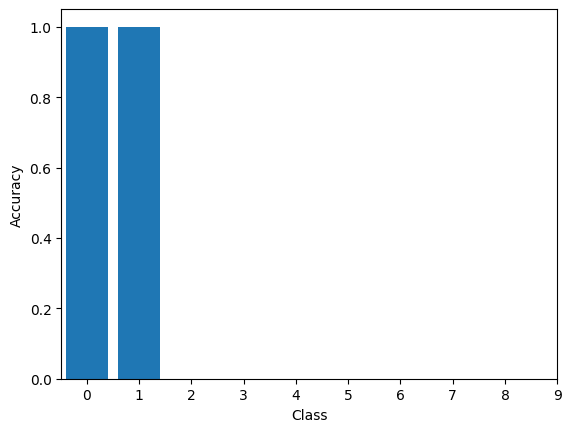

['100.00', '100.00', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']


100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


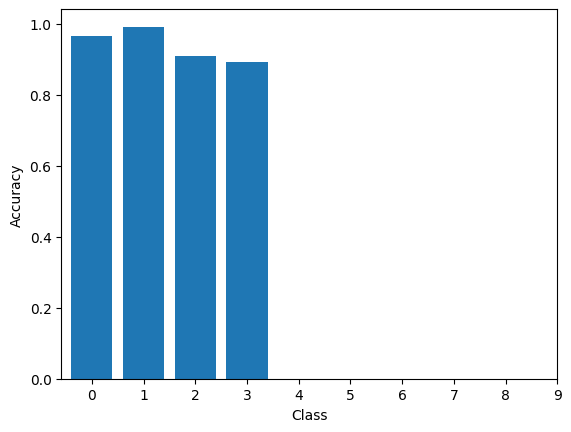

['96.63', '99.12', '90.79', '89.21', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']


100%|██████████| 20/20 [00:05<00:00,  3.99it/s]


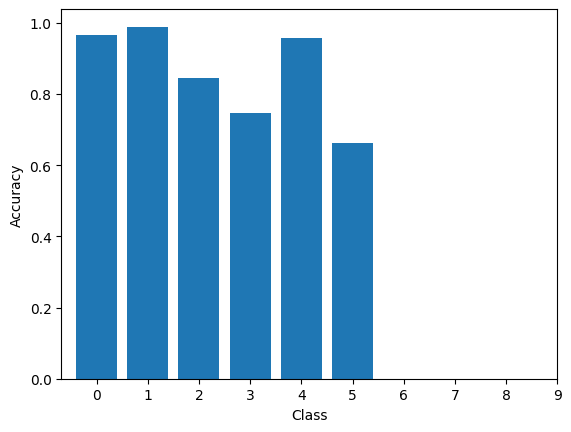

['96.53', '98.94', '84.40', '74.55', '95.72', '66.26', 'nan', 'nan', 'nan', 'nan']


100%|██████████| 20/20 [00:05<00:00,  3.53it/s]


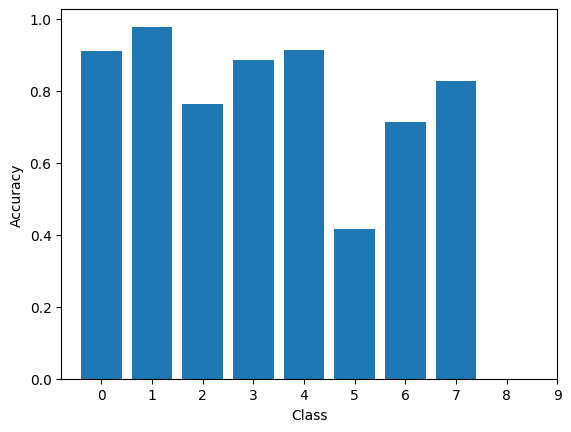

['90.92', '97.80', '76.45', '88.61', '91.34', '41.70', '71.19', '82.68', 'nan', 'nan']


100%|██████████| 20/20 [00:05<00:00,  3.69it/s]


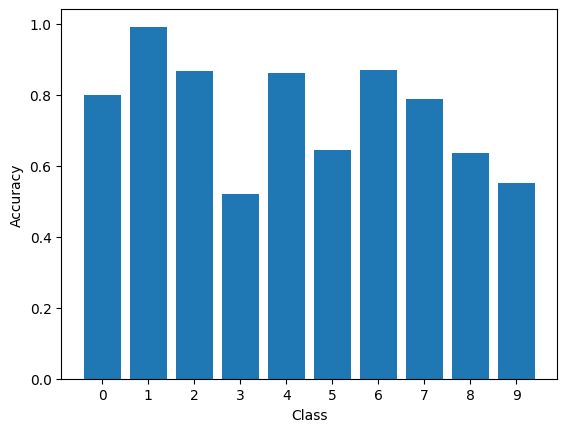

['80.00', '99.12', '86.63', '52.08', '85.95', '64.46', '86.95', '78.70', '63.45', '55.00']
A_last: 75.23 | A_avg: 87.07


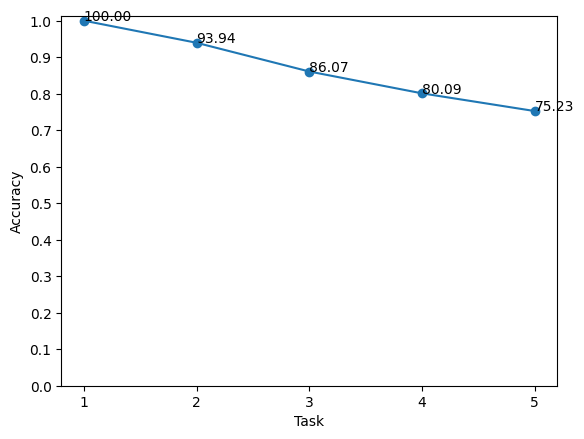

In [11]:
gdumb_method = GDumbMethod(data_root='./dataset', num_tasks=5, memory_size=500)
gdumb_method.train()